### stat_market home assignment

### improt libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from bubble_plot.bubble_plot import bubble_plot
import numpy as np
import seaborn as sns
import xgboost as xgb
import re
from sklearn.model_selection import StratifiedKFold
import shap
from sklearn.model_selection import train_test_split

### read data

In [114]:
df = pd.read_csv("C:/Users/davidog16/Desktop/stat_assign/diabetic_data.csv")

In [115]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [116]:
df.isnull().sum().sum()

0

### missing returns 0, but we can see that this data has unique signs for missing such as "?"

### hist for int type columns

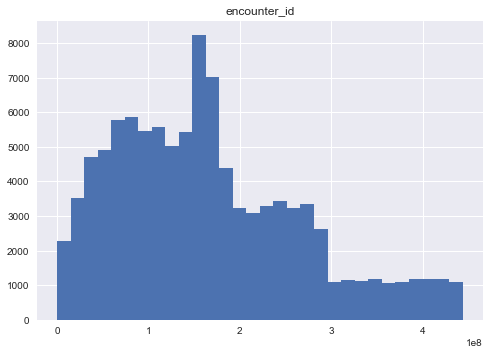

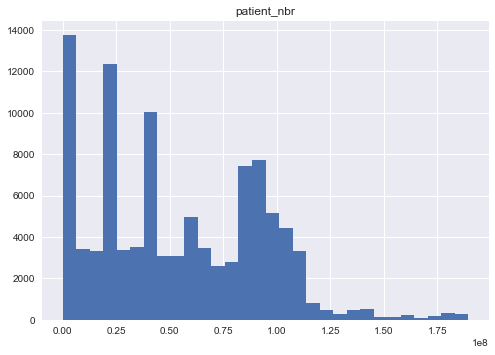

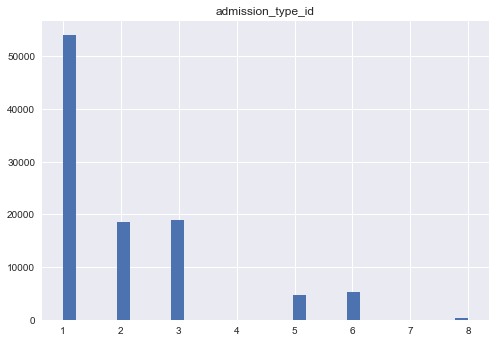

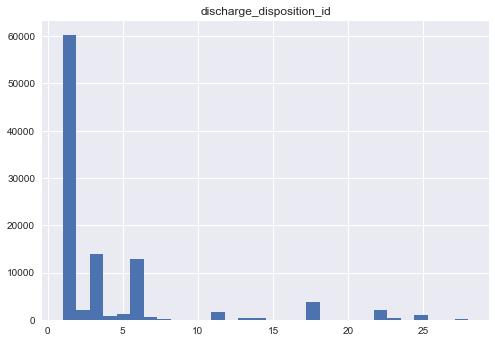

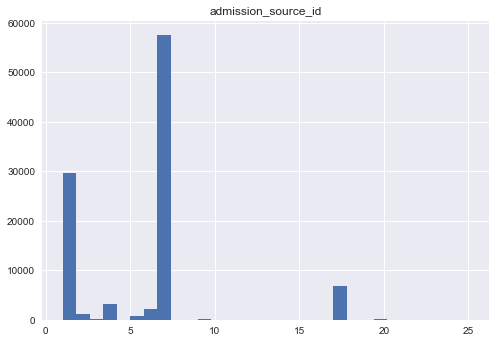

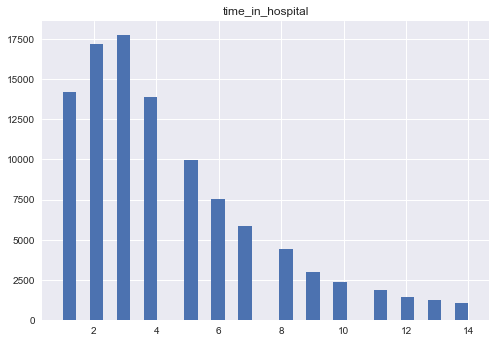

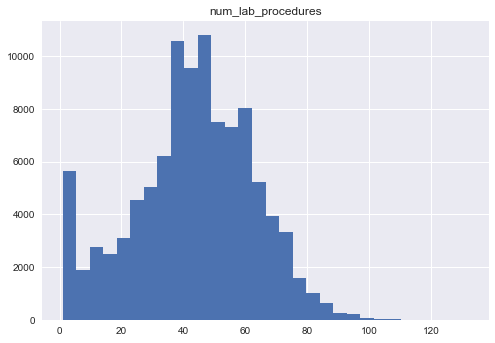

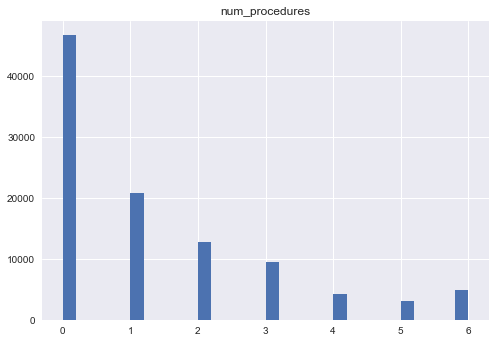

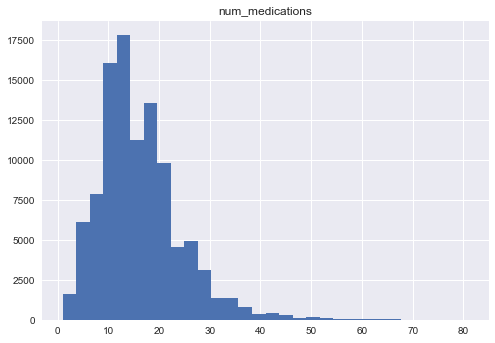

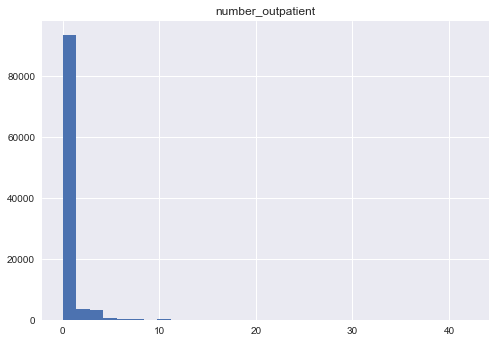

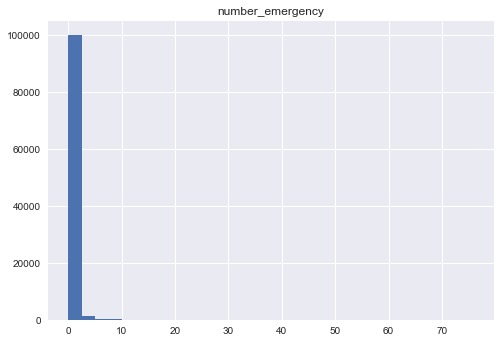

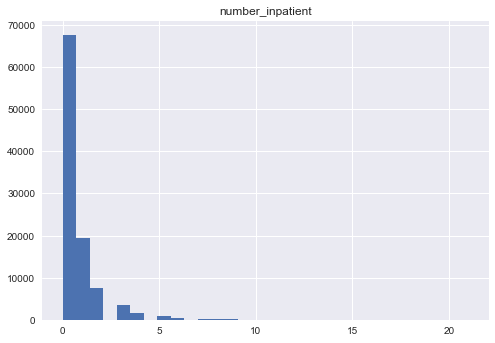

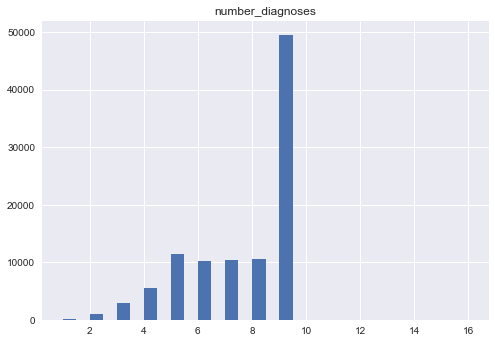

In [117]:
for col in df.select_dtypes(include=['int64']).columns.tolist():
    plt.hist(df[col],bins=30)
    plt.title(col)
    plt.show()

### hist insights: 
    1. some columns are not continous. will move them to the categorical list.

In [118]:
#list of discrete looking from hist
discrete = ['admission_type_id',"discharge_disposition_id","admission_source_id"]

#list of num's
nums = ["num_procedures","number_diagnoses"]
cat = df.select_dtypes(include=['object']).columns.tolist()
cat = cat + discrete
#remove id's
cat = [c for c in cat if c not in ["encounter_id","patient_nbr","readmitted"]+nums]

num = df.select_dtypes(include=['int64']).columns.tolist()
num = [c for c in num if c not in discrete+["encounter_id","patient_nbr","readmitted"]]

num = num + nums
num = list(set(num))

In [123]:
# convert age to numeric by this map:
map_age = {"[70-80)":70,
      "[60-70)":60,
      "[50-60)":50,
      "[80-90)":80,
      "[40-50)":40,
      "[30-40)":30,
      "[90-100)":90,
      "[20-30)":20,
      "[10-20)":10,
      "[0-10)":0}
df["age_num"] = df["age"].map(map_age)
df[["age","age_num"]].head()

,age,age_num
0,[0-10),0
1,[10-20),10
2,[20-30),20
3,[30-40),30
4,[40-50),40


In [124]:
num = num+['age_num']
cat.remove('age')

### plot correlation heat map

In [125]:
corr = df[num].corr()

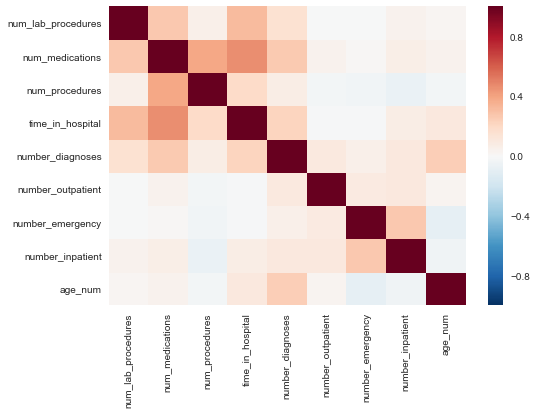

In [126]:
sns.heatmap(corr)
plt.show()

### corr insights: 
    1. time in hospital has high positive correlation with number of medications
    

In [111]:
#sns.pairplot(df[num+["readmitted"]], hue="readmitted")
#plt.show()

### examine the number of unique values per categorical feature with its distribution.

In [127]:
for col in cat:
    print("{}'s number of unique values: {} \n".format(col,df[col].nunique()))
    print(" and their distribution : \n")
    print(df[col].value_counts(normalize=True))
    print("\n")

race's number of unique values: 6 

 and their distribution : 

Caucasian          0.747784
AfricanAmerican    0.188766
?                  0.022336
Hispanic           0.020017
Other              0.014799
Asian              0.006299
Name: race, dtype: float64


gender's number of unique values: 3 

 and their distribution : 

Female             0.537586
Male               0.462384
Unknown/Invalid    0.000029
Name: gender, dtype: float64


weight's number of unique values: 10 

 and their distribution : 

?            0.968585
[75-100)     0.013128
[50-75)      0.008814
[100-125)    0.006142
[125-150)    0.001425
[25-50)      0.000953
[0-25)       0.000472
[150-175)    0.000344
[175-200)    0.000108
>200         0.000029
Name: weight, dtype: float64


payer_code's number of unique values: 18 

 and their distribution : 

?     0.395574
MC    0.318761
HM    0.061651
SP    0.049201
BC    0.045742
MD    0.034707
CP    0.024890
UN    0.024055
CM    0.019034
OG    0.010151
PO    0.005817
DM  

Name: A1Cresult, dtype: float64


metformin's number of unique values: 4 

 and their distribution : 

No        0.803589
Steady    0.180276
Up        0.010485
Down      0.005650
Name: metformin, dtype: float64


repaglinide's number of unique values: 4 

 and their distribution : 

No        0.984877
Steady    0.013600
Up        0.001081
Down      0.000442
Name: repaglinide, dtype: float64


nateglinide's number of unique values: 4 

 and their distribution : 

No        0.993092
Steady    0.006564
Up        0.000236
Down      0.000108
Name: nateglinide, dtype: float64


chlorpropamide's number of unique values: 4 

 and their distribution : 

No        0.999155
Steady    0.000776
Up        0.000059
Down      0.000010
Name: chlorpropamide, dtype: float64


glimepiride's number of unique values: 4 

 and their distribution : 

No        0.948991
Steady    0.045890
Up        0.003213
Down      0.001906
Name: glimepiride, dtype: float64


acetohexamide's number of unique values: 2 

 and

### we will apply a quick strategy for ategorical columns - bidding by 5%. all values that appear less then 5 % will be replaced by the string "other". and we will remove features with many values completely. in the future we should check the different values that enters "other" and perform hashing trick on the features removed.

In [128]:
#bidding
df[cat] = df[cat].apply(lambda x: x.mask(x.map(x.value_counts(normalize=True))<0.05, 'other'))

In [129]:
rmv = ['weight','repaglinide','nateglinide', 'diag_1','diag_2','diag_3','chlorpropamid','acetohexamide','tolbutamide','acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazon','']
cat = [c for c in cat if c not in rmv]
cat

['race',
 'gender',
 'payer_code',
 'medical_specialty',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'chlorpropamide',
 'glimepiride',
 'glipizide',
 'glyburide',
 'pioglitazone',
 'rosiglitazone',
 'insulin',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id']

### examining the change in the features

In [130]:
for col in cat:
    print("{}'s number of unique values: {} \n".format(col,df[col].nunique()))
    print(" and their distribution : \n")
    print(df[col].value_counts(normalize=True))
    print("\n")

race's number of unique values: 3 

 and their distribution : 

Caucasian          0.747784
AfricanAmerican    0.188766
other              0.063449
Name: race, dtype: float64


gender's number of unique values: 3 

 and their distribution : 

Female    0.537586
Male      0.462384
other     0.000029
Name: gender, dtype: float64


payer_code's number of unique values: 4 

 and their distribution : 

?        0.395574
MC       0.318761
other    0.224014
HM       0.061651
Name: payer_code, dtype: float64


medical_specialty's number of unique values: 6 

 and their distribution : 

?                         0.490822
other                     0.165330
InternalMedicine          0.143810
Emergency/Trauma          0.074337
Family/GeneralPractice    0.073109
Cardiology                0.052591
Name: medical_specialty, dtype: float64


max_glu_serum's number of unique values: 2 

 and their distribution : 

None     0.947468
other    0.052532
Name: max_glu_serum, dtype: float64


A1Cresult's numb

In [68]:
df = df[df["gender"]!="Unknown/Invalid"]

### plotting bar plots. the top of the bar shows the chance of being above_30 for each value.
### plus the black line is the confidence interval. overlapping lines means that there is no difference between these values "chances" (mean)

C:\Users\davidog16\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


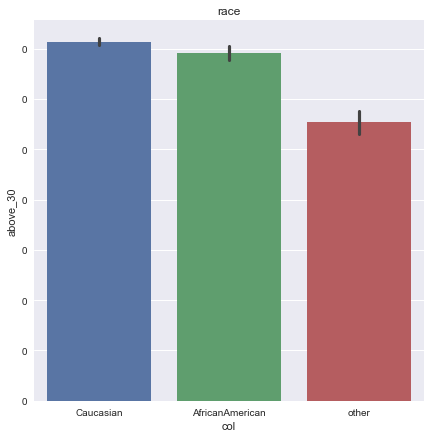

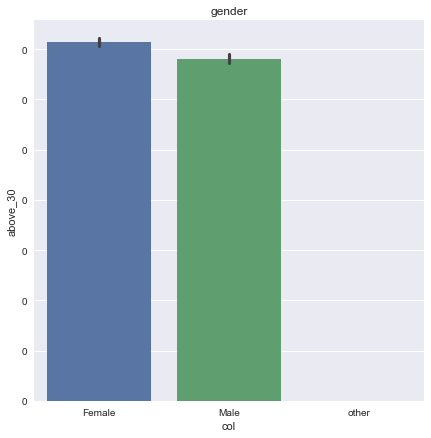

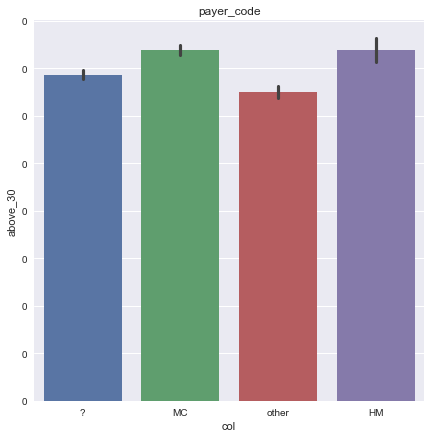

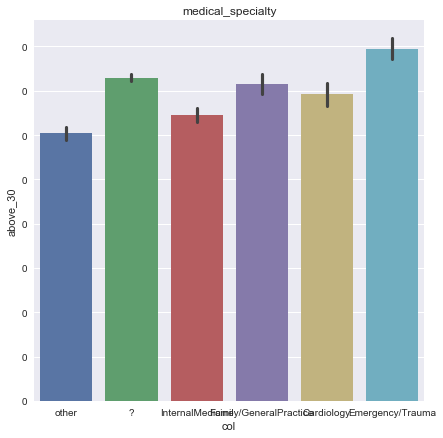

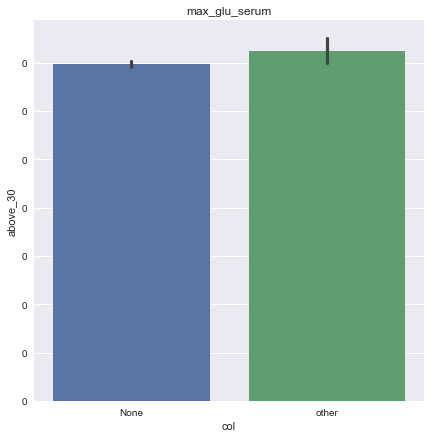

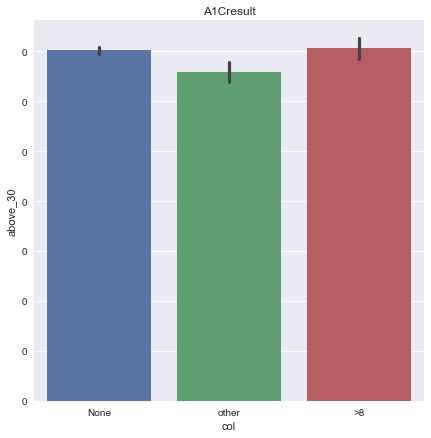

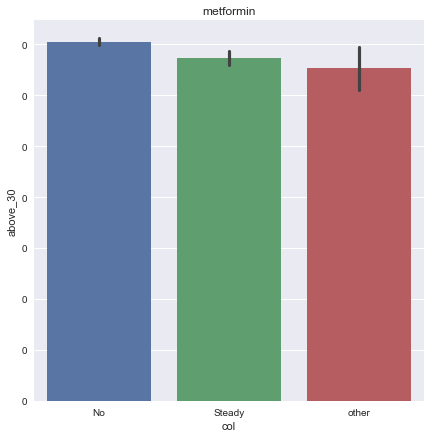

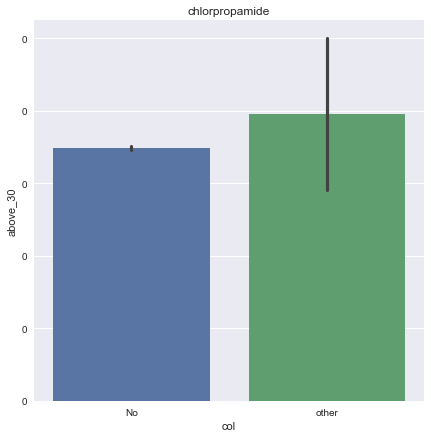

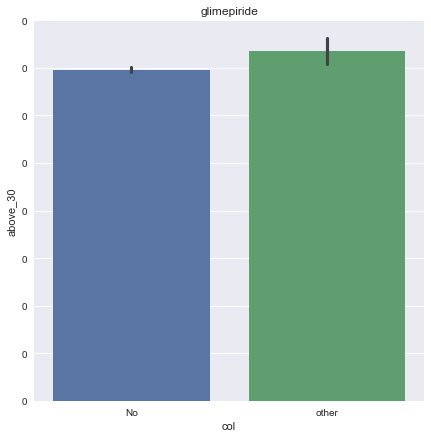

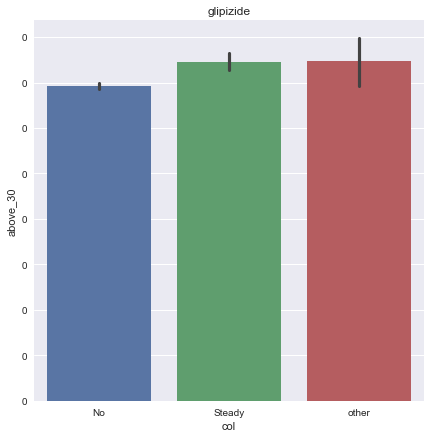

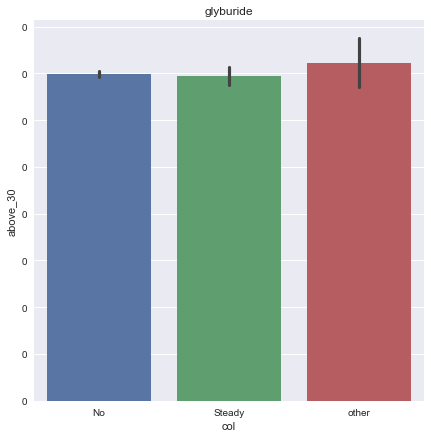

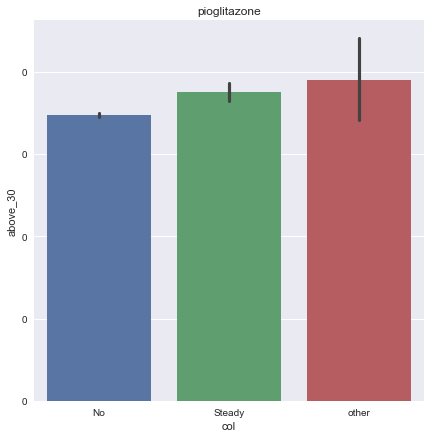

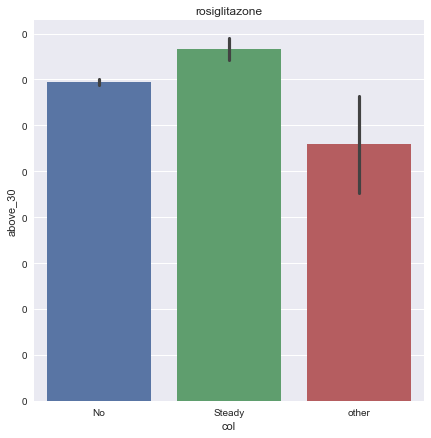

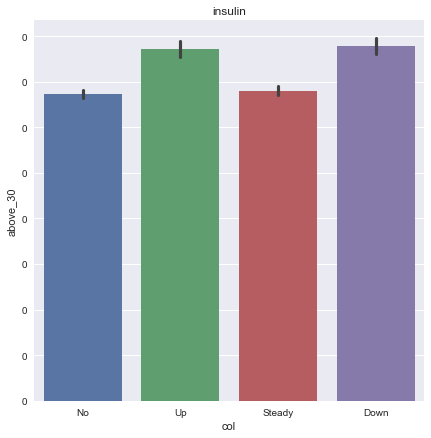

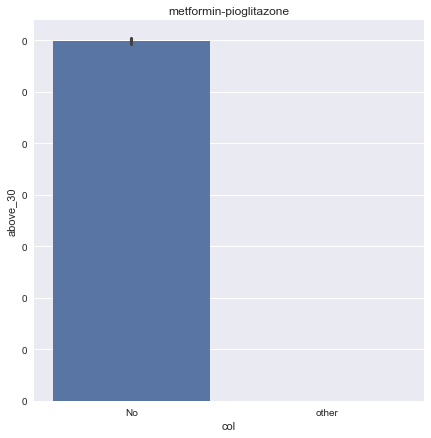

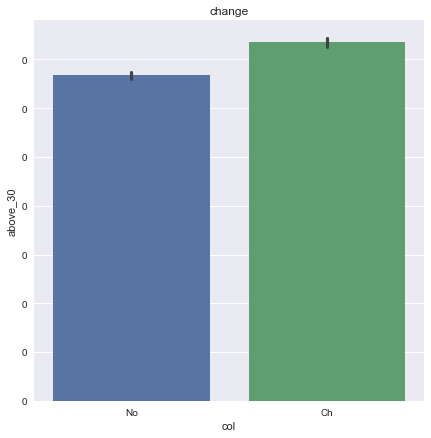

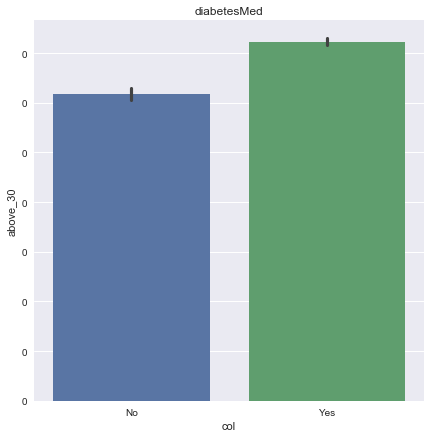

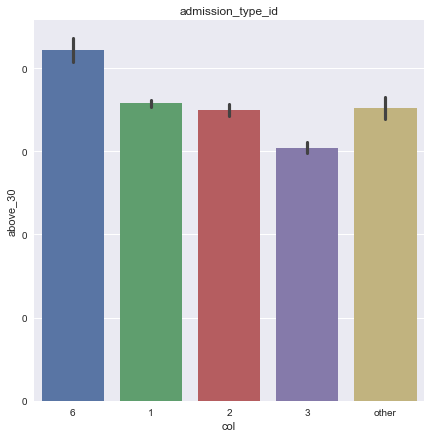

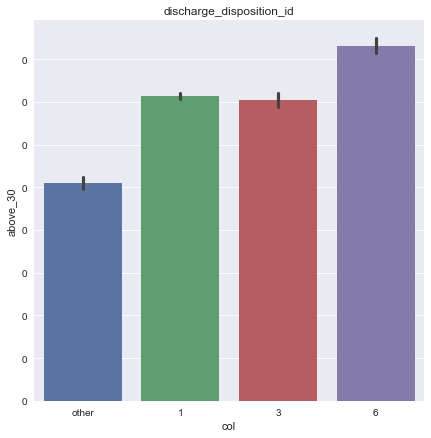

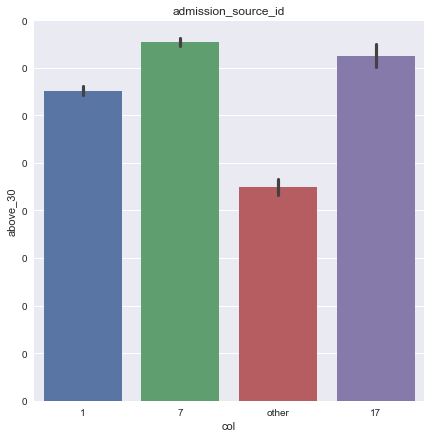

In [134]:
for col in cat :
   
        plt.figure(figsize=(7,7))
        ax = sns.barplot(data=df, x= col, y = np.where(df['readmitted']==">30",1,0))
        ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
        ax.set(xlabel="col", ylabel='above_30')
        ax.set(ylabel = 'above_30')
        plt.title(col)
        plt.show()

### above_30 bar plot insights:
    1. as for race, caucassian and afrecan america have higher rates of being <30 then other
    2. as for gender, males have lower chances of radmitting >30
    3. etc
    
    features that do not have any difference in mean :  glyburide, pioglitazone, chlorpropamide

### plotting bar plots. the top of the bar shows the chance of being under_30 for each value.
### plus the black line is the confidence interval. overlapping lines meaning that there is no difference between these values "chances" (mean)

C:\Users\davidog16\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


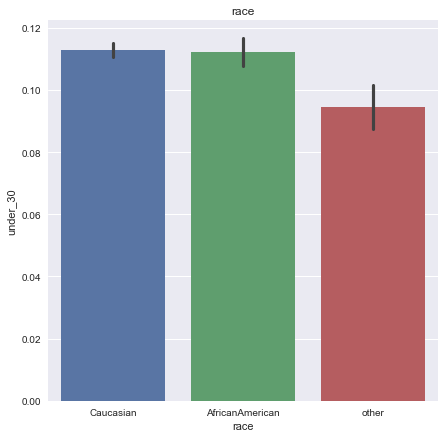

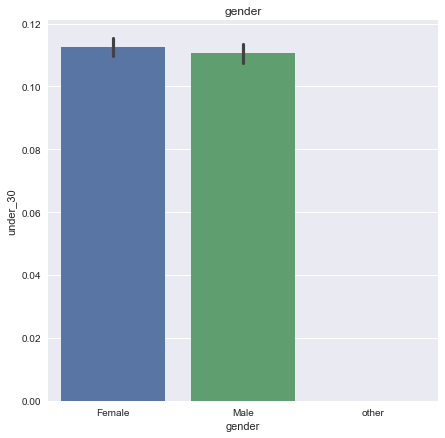

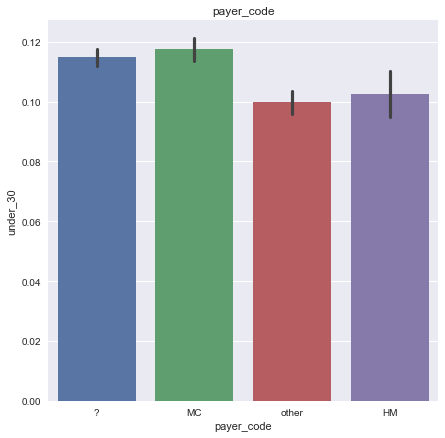

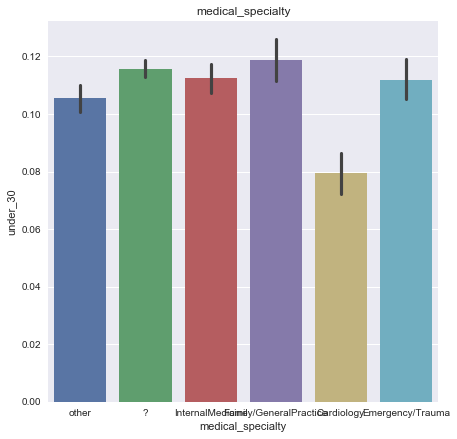

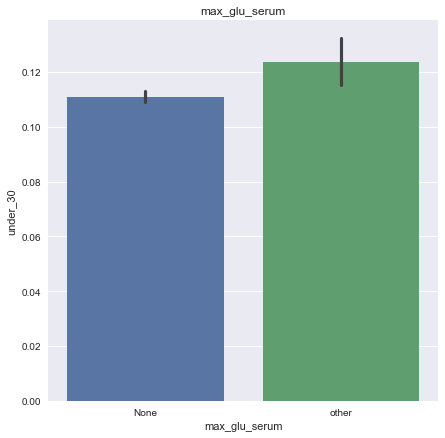

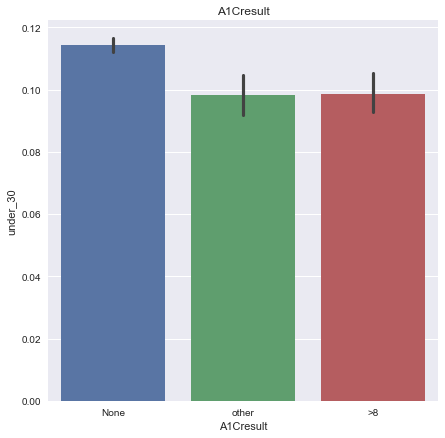

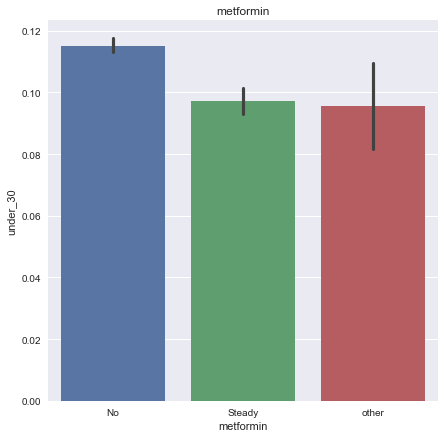

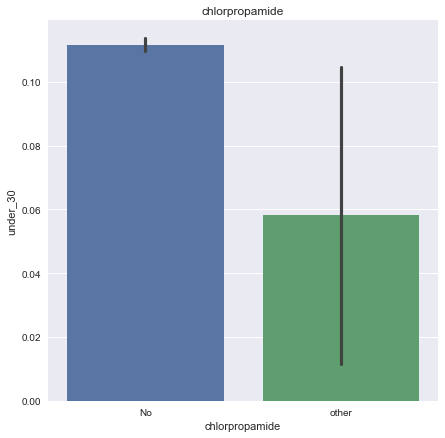

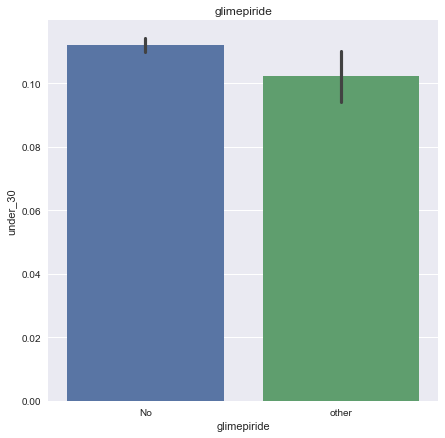

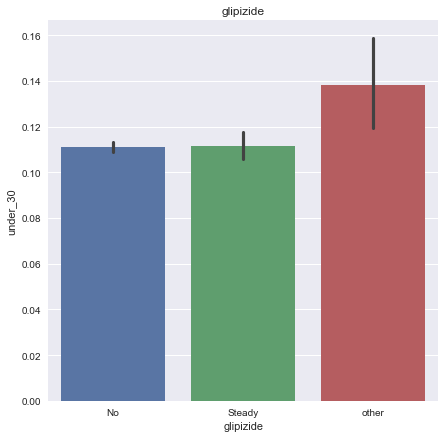

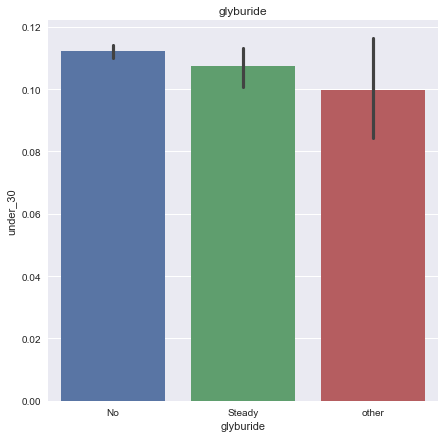

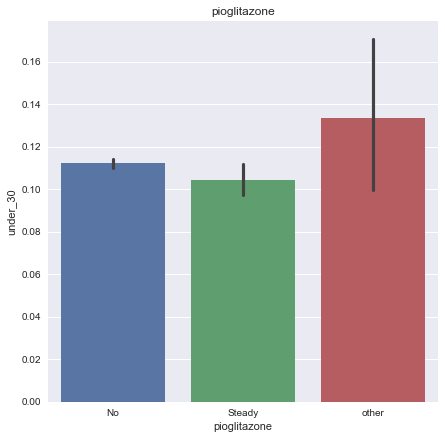

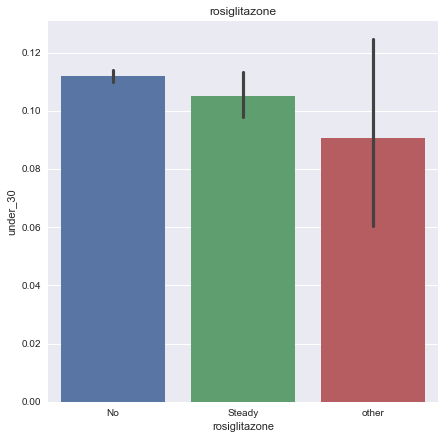

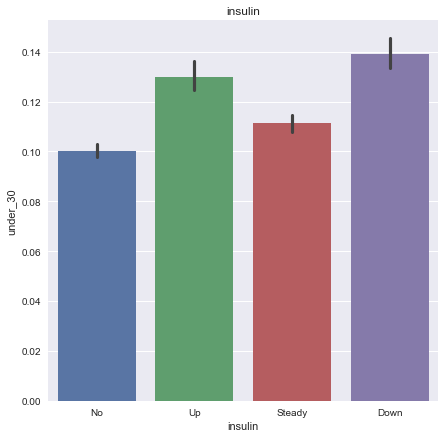

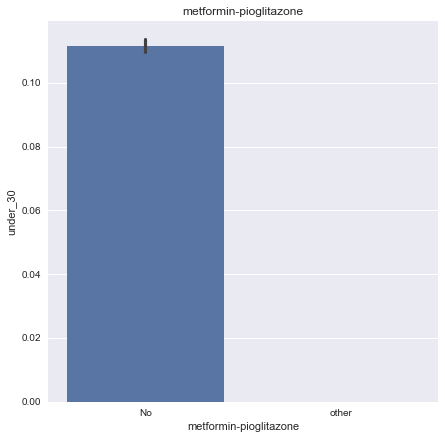

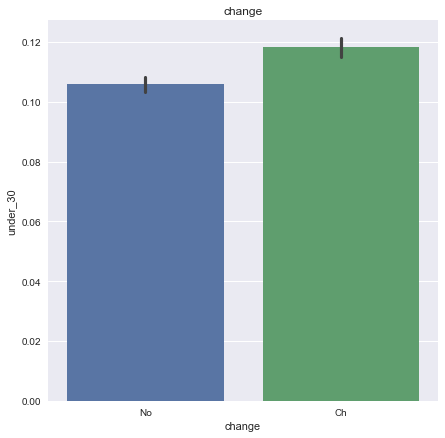

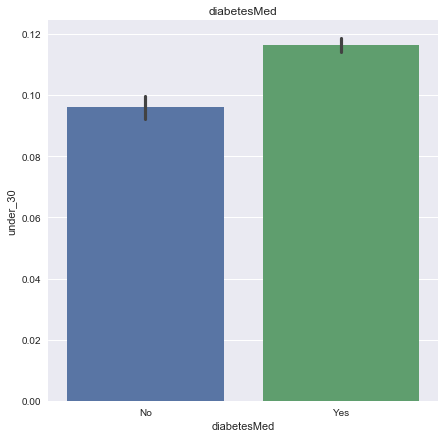

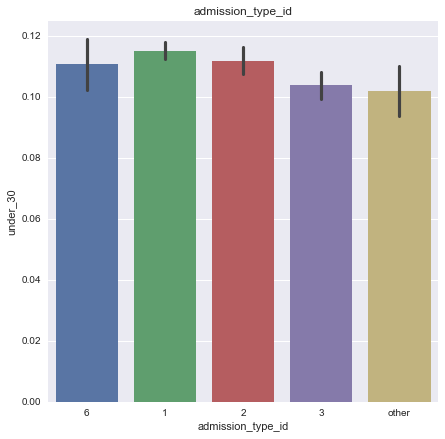

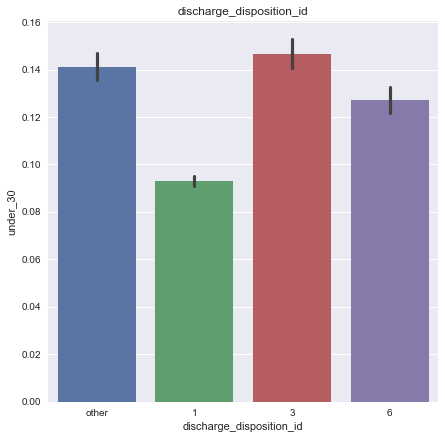

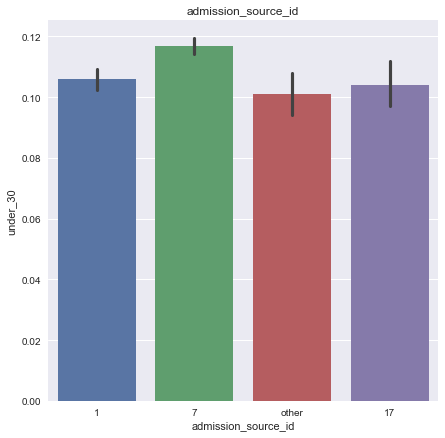

In [135]:
for col in cat:
        plt.figure(figsize=(7,7))
        ax = sns.barplot(data=df, x= col, y = np.where(df['readmitted']=="<30",1,0))
        ax.set(ylabel = 'under_30')
        plt.title(col)
        plt.show()

### under_30 bar plot insights:
    1. as for race, caucassian and afrecan america have higher rates of being <30 then other
    2. as for payer_code, ? (missing), and MC have higher rates then "other" (low frequency values) and HM
    3. etc
    
    features that do not have any difference in mean : gender, glimepiride, glyburide, pioglitazone, rosiglitazone, 

### add dummy columns for categorical features

In [136]:
dummies = pd.get_dummies(df[cat])
dummy_cols = dummies.columns.tolist()

In [137]:
df = pd.concat([df,dummies],axis=1)

In [138]:
x_col = num + dummy_cols

### convert label to int for xgboost

In [139]:
label_map = {"NO":0,">30":1,"<30":2}
df['y'] = df["readmitted"].map(label_map)

In [140]:
# make sure all is num
for c in x_col+['y']:
    df[c] = df[c].astype(int)

### change column nams for xgboost

In [141]:
#xgb.DMAtrix dosent like < in column names
aregex = re.compile(r"\[|\]|<", re.IGNORECASE)
df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]
dummy_cols = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in dummy_cols]
x_col = num + dummy_cols

### define the function that trains xgboost stratified cross validated models

In [142]:
def train_xgb_cv(X,Y):
    
    '''
    a function that train's a stratified cross validated xgboost multi class classifier,
    and prints the resulted train and test error.
    
    param X : pd.DataFrame
    param Y : pd.DataFrame
    
    returns last trained model
    '''
    
    skf = StratifiedKFold(n_splits=3,shuffle=True)
    

    for train_index, test_index in skf.split(X,Y):
        print(train_index)
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        
        param = {"objective" :'multi:softmax',
                 "num_class":3,
                 "colsample_bytree":1,
                 "learning_rate":0.3,
                 "max_depth":12,
                 "subsample":1,
                 "seed":42,
                 'eval_metric': 'mlogloss',
                 'base_score': 0.3,
                 #'alpha':10
                     }
        
        num_round=10
        #weight=np.where(y_train["answer"]==1,1,0.7)
        dtrain = xgb.DMatrix(X_train, label=y_train)  #,weight=weight
        dtest = xgb.DMatrix(X_test, label=y_test)

        watchlist=[(dtrain,'train'),(dtest,'test')]
        progress={}
        bst = xgb.train(param, dtrain,num_round,evals=watchlist,early_stopping_rounds=5,evals_result=progress)
        
        plt.plot([i for i in range(num_round)],progress["train"]["mlogloss"],label="train")
        plt.plot([i for i in range(num_round)],progress["test"]["mlogloss"],label="train")
        plt.xlabel('iteration')
        plt.ylabel('logloss')
        plt.show()
        
    return bst
 

### split into train and held out data

In [143]:
X_train, X_test, y_train, y_test = train_test_split(df[x_col], df['y'], test_size=0.2, random_state=42,stratify=df['y'])


[    1     2     3 ... 81409 81410 81411]
[0]	train-mlogloss:0.987122	test-mlogloss:1.02049
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 5 rounds.
[1]	train-mlogloss:0.911378	test-mlogloss:0.974991
[2]	train-mlogloss:0.855102	test-mlogloss:0.946401
[3]	train-mlogloss:0.812086	test-mlogloss:0.928091
[4]	train-mlogloss:0.780156	test-mlogloss:0.91677
[5]	train-mlogloss:0.751068	test-mlogloss:0.90948
[6]	train-mlogloss:0.726827	test-mlogloss:0.904781
[7]	train-mlogloss:0.706063	test-mlogloss:0.901637
[8]	train-mlogloss:0.689023	test-mlogloss:0.900003
[9]	train-mlogloss:0.670729	test-mlogloss:0.899102


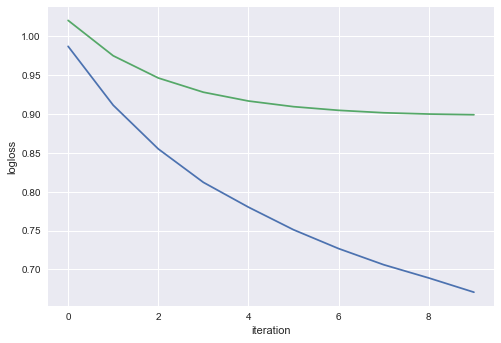

[    0     5     9 ... 81408 81409 81410]
[0]	train-mlogloss:0.986526	test-mlogloss:1.02233
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 5 rounds.
[1]	train-mlogloss:0.907589	test-mlogloss:0.977149
[2]	train-mlogloss:0.851077	test-mlogloss:0.948074
[3]	train-mlogloss:0.806556	test-mlogloss:0.930299
[4]	train-mlogloss:0.771262	test-mlogloss:0.919119
[5]	train-mlogloss:0.740556	test-mlogloss:0.912587
[6]	train-mlogloss:0.71513	test-mlogloss:0.908146
[7]	train-mlogloss:0.694331	test-mlogloss:0.905438
[8]	train-mlogloss:0.676066	test-mlogloss:0.903725
[9]	train-mlogloss:0.659559	test-mlogloss:0.902523


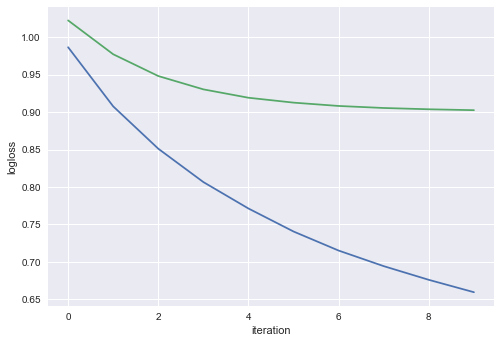

[    0     1     2 ... 81406 81407 81411]
[0]	train-mlogloss:0.986061	test-mlogloss:1.02146
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 5 rounds.
[1]	train-mlogloss:0.909197	test-mlogloss:0.975938
[2]	train-mlogloss:0.853043	test-mlogloss:0.947276
[3]	train-mlogloss:0.808441	test-mlogloss:0.929889
[4]	train-mlogloss:0.773336	test-mlogloss:0.918637
[5]	train-mlogloss:0.742504	test-mlogloss:0.910773
[6]	train-mlogloss:0.718775	test-mlogloss:0.905825
[7]	train-mlogloss:0.698201	test-mlogloss:0.902884
[8]	train-mlogloss:0.679045	test-mlogloss:0.901052
[9]	train-mlogloss:0.662372	test-mlogloss:0.900224


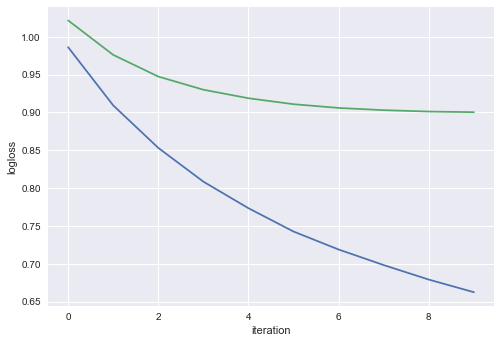

In [144]:
bst = train_xgb_cv(X_train,y_train)

### with these params (high depth) and features, most of the learning is done in a few iterations.
### as for model performance, lower depth and eta with more iterations will probably reach a better model. (not to mention param tunning)

### define and use a function that plots the feature importance of our ensemble model.

In [145]:
def importance(model,importance_type='gain',write=False,path=""):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca()
    xgb.plot_importance(model, max_num_features=30, height=0.8, ax=ax,importance_type=importance_type)
    if write:
       plt.savefig('{}/importance.png'.format(path))

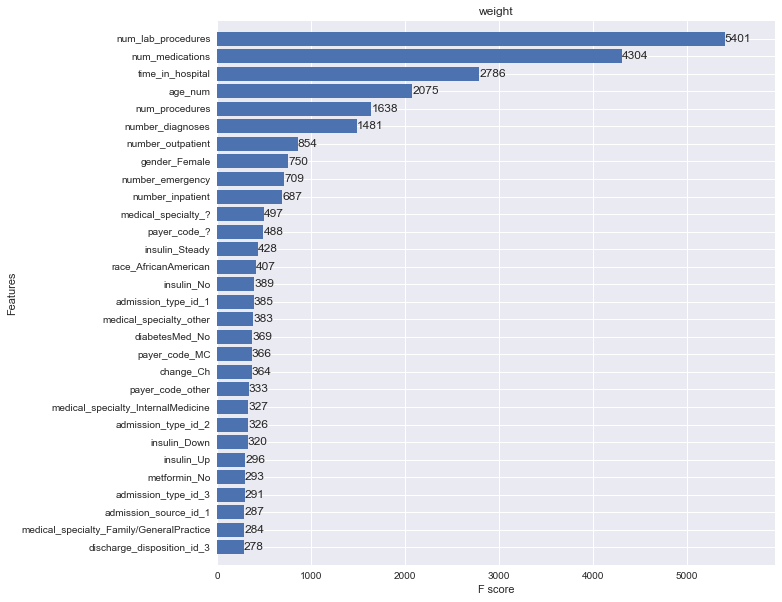

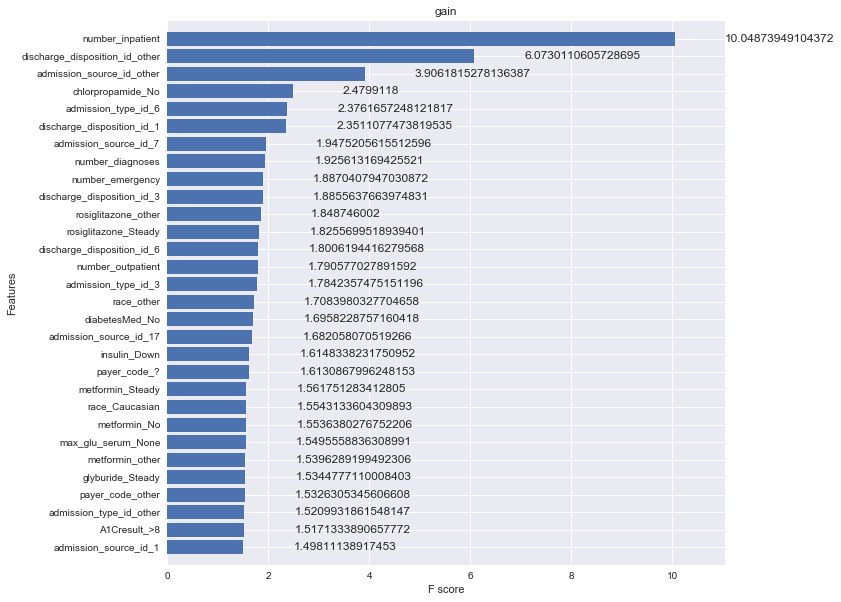

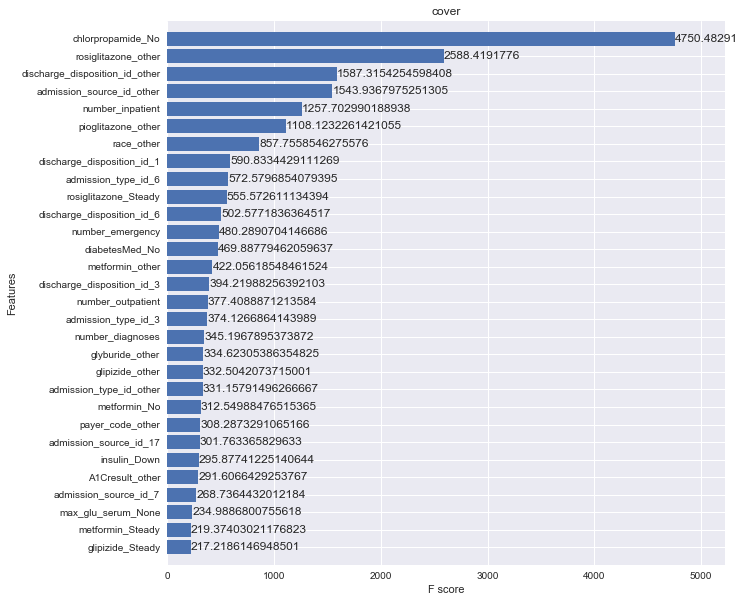

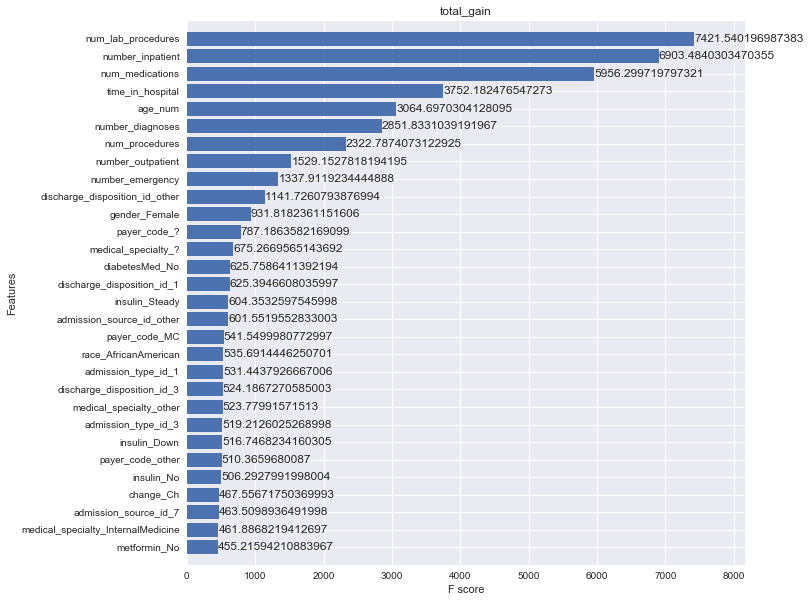

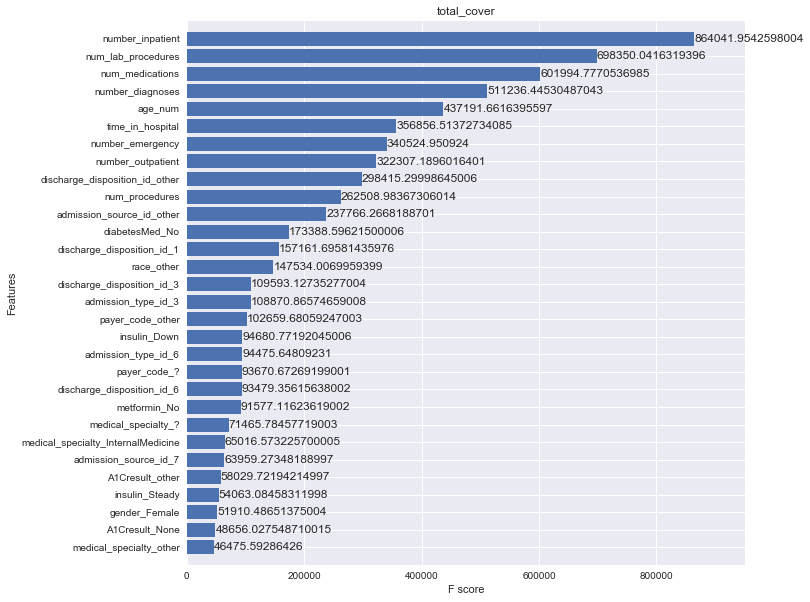

In [146]:
importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
for f in importance_types :
    importance(bst,importance_type=f)
    plt.title(f)
    plt.show()

### importance plots insghts:
    1. number_inpatient is the feature that provides the highest gain and is the fifth in terms of cover.
    2. the second and third most important features are the "other" that replaced low frequency values, therefore they most be checked, maybe there is a specific value inside all of the "others" that drives the gain high.

In [147]:
shap_values = shap.TreeExplainer(bst).shap_values(X_test[x_col])

### shap summary plot for NO readmitted

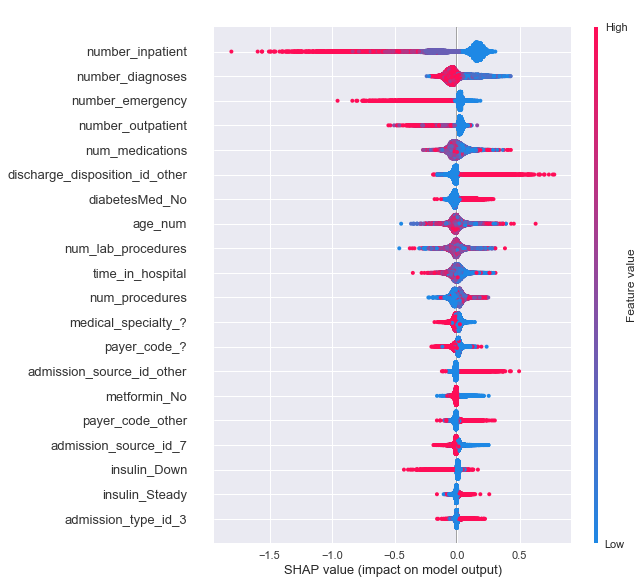

In [148]:
shap.summary_plot(shap_values[0], X_test)

### NO readmitted shap insights:
    1. the lower the number_inpatient the higher the chance for being NO readmitted.
    2. same for number _diagnoses
    3. when diabetedMed = NO the higher the chance of being readmitted NO
    3. etc

### shap summary plot for >30 readmitted

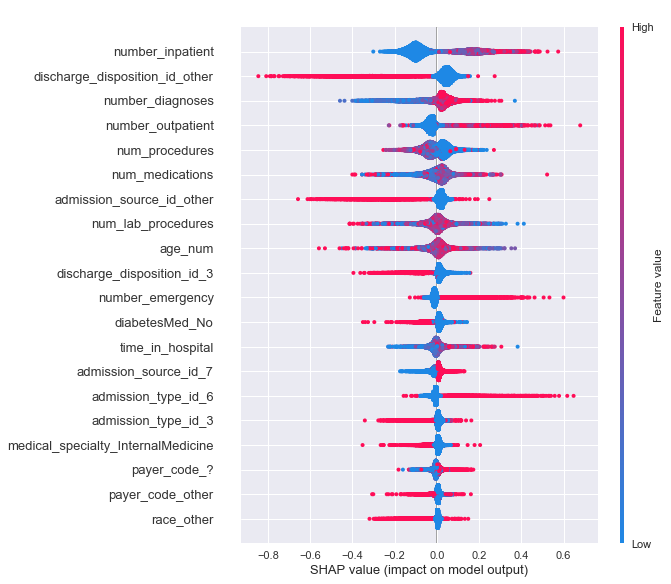

In [149]:
shap.summary_plot(shap_values[1], X_test)

### above 30 readmitted shap insights:
    1. the higher the number_inpatient the higher the prediction for being >30 readmitted.
    2. same for number _diagnoses
    3. when diabetedMed = NO the lower the prediction of being readmitted >30
    3. etc

### shap summary plot for <30 readmitted

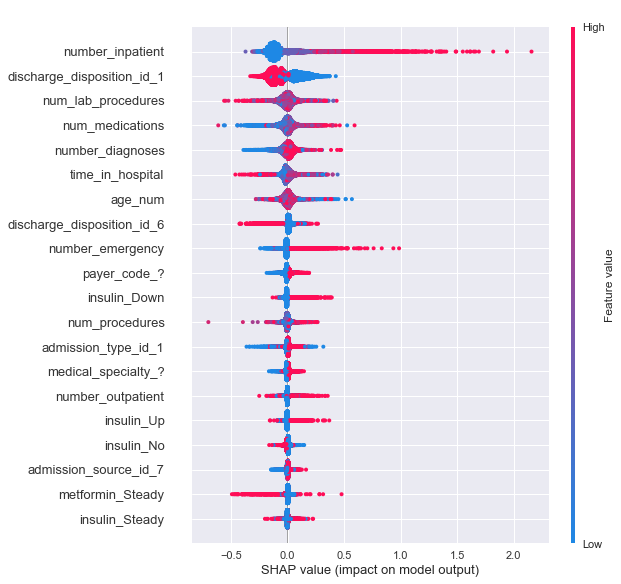

In [150]:
shap.summary_plot(shap_values[2], X_test)

### under 30 readmitted shap insights:
    1. the higher the number_inpatient the higher the prediction for being <30 readmitted.
    2. same for number _diagnoses
    3. when discharge_disposition_id =1 the lower the prediction are of being readmittted <30
    3. etc

### lets look for interactions (on > 30)

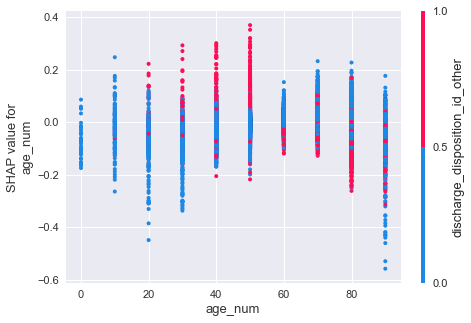

In [152]:
shap.dependence_plot("age_num", shap_values[1], X_test)

### age dependence plot insight:
    1. up to age 50, when discharge disposition id = other (low frequency value, could be a specific value inside should to check that), it pushes the prediction up, while after age 50 it pushes the prediction down.

### conclusion:
it is always fun to investigate fresh data.

more things I would have done:

    pair plot, 
    chi square test, 
    feature scaling, 
    feature engineerinrg, 
    param optimzation, 
    test more interactions and add features based on them,
    test more algos.
    deal with missing values.
    get info of data origin.
    check if should have used group k fold by patient_id. (maybe some patients with almsot the same feaures have higher rates and the model can learn to identify the patient)